In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numba as nb
from scipy import signal

%config InlineBackend.figure_formats = ['svg']

# O-U process and check noise function

In [4]:
# generate OU process that should have NPS with cut freq 1/(2 pi tau)

In [5]:
def eulmaj(dX, t, X0, *args):
    assert len(t.shape) == 1, ''
    X = np.zeros(t.shape)
    X[0] = X0
    for i,t_ in tqdm(enumerate(t[1:]), total=t.shape[0] - 1):
        X[i+1] = X[i] + dX(X[i], t[i+1] - t[i], *args)
    return X

In [6]:
@nb.njit
def dX(X, dt, tau, c):
    return - 1 / tau * X * dt + np.sqrt(c*dt) * np.random.normal()

In [7]:
sample_frequency = 25_000
record_length = 16_384
nmbr = 20
t = np.arange(0,record_length*nmbr)/sample_frequency

In [8]:
c = .5
tau = 0.0002
std = np.sqrt(c*tau/2)
X0 = np.random.normal(scale=std)
gf = 1/(2*np.pi*tau)
print('std: ', std)
print('start value: ', X0)
print('expected GF: {} Hz'.format(gf))

std:  0.007071067811865475
start value:  -0.0005272405543560718
expected GF: 795.7747154594767 Hz


In [9]:
X = eulmaj(dX, t, X0, tau, c)

  0%|          | 0/327679 [00:00<?, ?it/s]

tau = 0.0002 c = 0.5 reclen = 16384 samfq = 25000 gives wrong by 1.0944324500268918
Simulated std  0.007439837104081247


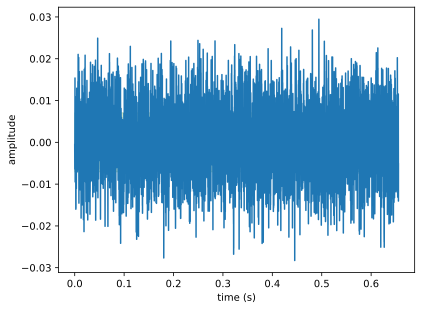

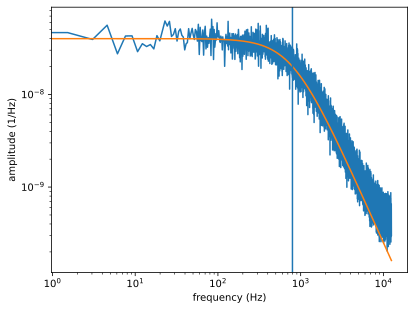

In [10]:
freq = np.fft.rfftfreq(record_length, 1/sample_frequency)
norm_factor = 2 / sample_frequency / record_length #/ 0.875 # window factor
norm_back_factor = 1 / norm_factor / record_length ** 2 #/ 0.875 # window factor
nps = np.mean(np.abs(np.fft.rfft(X.reshape(-1, record_length), axis=-1, norm='backward'))**2, axis=0) * norm_factor
nps_calc = 2*c*tau**2/(1 + (2*np.pi*tau*freq)**2)

print('tau = {} c = {} reclen = {} samfq = {} gives wrong by {}'.format(tau, c, record_length, sample_frequency, np.mean(nps[:1000]/nps_calc[:1000])))
print('Simulated std ', np.std(X))

plt.fill_between(t[:record_length], - std, std, alpha=0.2, color='green')
plt.plot(t[:record_length], X[:record_length])
plt.ylabel('amplitude')
plt.xlabel('time (s)')
plt.show()

plt.loglog(freq, nps)
plt.loglog(freq, nps_calc)
plt.axvline(gf)
plt.ylabel('amplitude (1/Hz)')
plt.xlabel('frequency (Hz)')
plt.show()

In [11]:
def noise_function(nps, size):
    f = np.sqrt(nps * norm_back_factor)
    f = np.array(f, dtype='complex')  # create array for frequencies
    f = np.tile(f, (size, 1))
    phases = np.random.rand(size, nps.shape[0]) * 2 * np.pi  # create random phases
    phases = np.cos(phases) + 1j * np.sin(phases)
    f *= phases
    return np.fft.irfft(f, axis=-1, norm='forward') 

def get_noise_bl(nps):
    noise = noise_function(nps, size=1)[0]  # in muA  #  * (1 + 0.01 * np.random.normal())
    return noise  # in V

In [12]:
X_sim = get_noise_bl(nps)

tau = 0.0002 c = 0.5 reclen = 16384 samfq = 25000 gives wrong by 0.9997693004762983
Reconstructed simulated std  0.007438120737204917


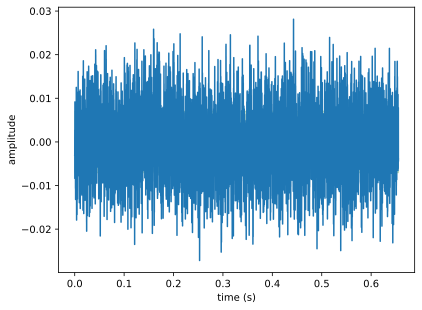

In [13]:
print('tau = {} c = {} reclen = {} samfq = {} gives wrong by {}'.format(tau, c, record_length, sample_frequency, 
                                                                        np.std(X_sim)/np.std(X)))
print('Reconstructed simulated std ', np.std(X_sim))
plt.fill_between(t[:record_length], std, -std, alpha=0.2, color='green')
plt.plot(t[:record_length], X_sim[:record_length])
plt.ylabel('amplitude')
plt.xlabel('time (s)')
plt.show()

# Check correct NPS normalization 

In [14]:
import numpy as np
import matplotlib.pyplot as plt


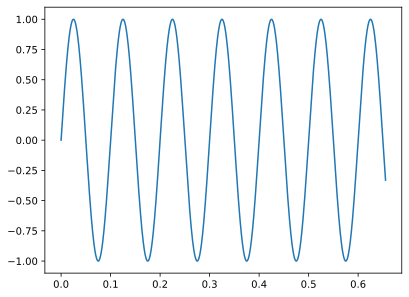

In [15]:
sampling_frequency = 25000
rec_len = 16384
t = np.linspace(0,rec_len/sampling_frequency,rec_len)
dt = t[1] - t[0]
ts = np.sin(2*np.pi*t*10)
freq = np.fft.rfftfreq(t.shape[0], dt)

plt.plot(t, ts)

14335.124999983913 0.8749465942372994


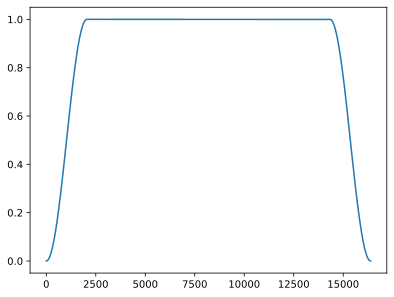

In [16]:
print(np.sum(signal.windows.tukey(rec_len, alpha=0.25)), 14335.124999983913/rec_len)
plt.plot(signal.windows.tukey(rec_len, alpha=0.25))

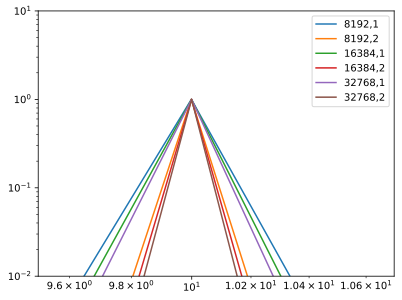

In [17]:
for rec_len in [8192, 8192*2, 8192*4]:
    for interval in [1,2]:
        t = np.linspace(0,interval,rec_len)
        dt = t[1] - t[0]
        ts = np.sin(2*np.pi*np.tile(t, 100).reshape(100,rec_len)*10)
        freq = np.fft.rfftfreq(t.shape[0], dt)
        # spectrum = np.mean(np.abs(np.fft.rfft(ts)) ** 2 * (2 / rec_len / sample_frequency), axis=0)
        spectrum = np.mean(np.abs(np.fft.rfft(ts)) ** 2 * (2 / rec_len)**2, axis=0)
        
        plt.loglog(freq, spectrum, label='{},{}'.format(rec_len, interval))
plt.legend()
plt.ylim(1e-2, 1e1)
plt.xlim(9.5, 10.7)
plt.show()

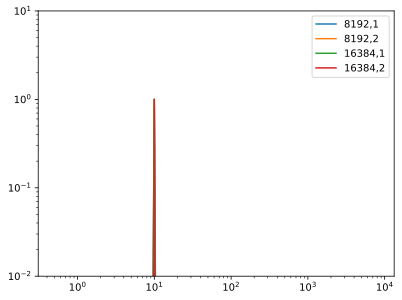

In [18]:
for rec_len in [8192, 16384]:
    for interval in [1,2]:
        t = np.linspace(0,interval,rec_len)
        dt = t[1] - t[0]
        ts = np.sin(2*np.pi*np.tile(t, 100).reshape(100,rec_len)*10)
        freq = np.fft.fftfreq(t.shape[0], dt)
        spectrum = np.mean(np.abs(np.fft.fft(ts)) ** 2 * (2 / rec_len) ** 2, axis=0) #* dt

        plt.loglog(freq, spectrum, label='{},{}'.format(rec_len, interval))
plt.legend()
plt.ylim(1e-2, 1e1)
plt.show()

# NPS of telegraph noise

In [19]:
nmbr_baselines = 1000
rec_len = 16384
sample_frequency = 25000
freq = np.fft.rfftfreq(rec_len, 1/sample_frequency)
expecteds = [0.1, 1, 10]
amplitude = 1

white_amp = 5

In [20]:
all_nps = []
all_noise_traces = []
all_noise_jumps = []

for e_jumps in expecteds:
    next_state = np.random.randint(1)
    noise_trace = np.mod(next_state + 1,2)*np.zeros((nmbr_baselines, rec_len))  
    
    for i in range(nmbr_baselines):
        n_jumps = np.random.poisson(e_jumps)
        jumps = np.sort(np.random.randint(0,rec_len, size=n_jumps))
        for j in jumps:
            noise_trace[i,j:] = next_state
            next_state += 1
            next_state = np.mod(next_state,2)
            
    noise_trace *= amplitude
    all_noise_jumps.append(np.copy(noise_trace))
    noise_trace += white_amp*np.random.normal(size=(nmbr_baselines, rec_len))
    all_noise_traces.append(noise_trace)
    nps = np.mean(np.abs(np.fft.rfft(noise_trace, axis=-1))**2 * (2 / rec_len) ** 2, axis=0)
    all_nps.append(nps)

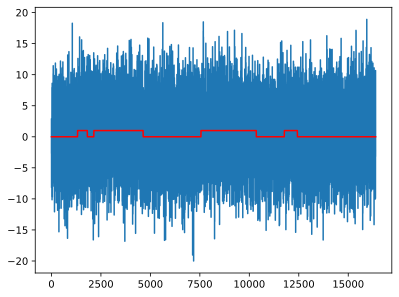

In [21]:
i = 2
j = 10
plt.plot(all_noise_traces[i][j])
plt.plot(all_noise_jumps[i][j], color='red')
plt.show()

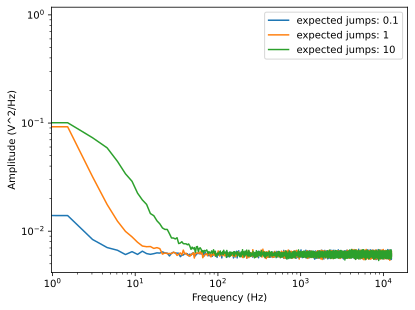

In [22]:
for nps, expected in zip(all_nps, expecteds):
    plt.loglog(freq, nps, label='expected jumps: {}'.format(expected))
plt.ylabel('Amplitude (V^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

# plot for diss

  0%|          | 0/327679 [00:00<?, ?it/s]

  0%|          | 0/327679 [00:00<?, ?it/s]

  0%|          | 0/327679 [00:00<?, ?it/s]

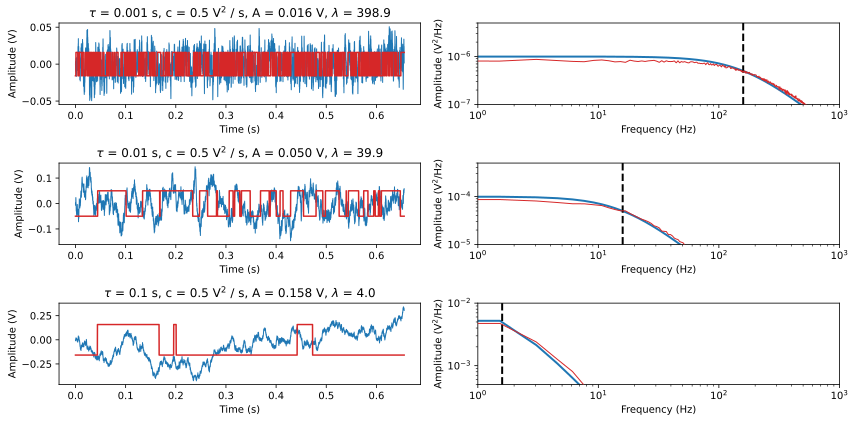

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(12,6), dpi=300)

# --------------------------------------------
# OU noise trace
# --------------------------------------------

sample_frequency = 25_000
record_length = 16_384
nmbr = 20
t = np.arange(0,record_length*nmbr)/sample_frequency
c = .5
tau1 = 0.001
tau2 = 0.01
tau3 = 0.1
std1 = np.sqrt(c*tau1/2)
std2 = np.sqrt(c*tau2/2)
std3 = np.sqrt(c*tau3/2)
X0 = np.random.normal(scale=std)
gf1 = 1/(2*np.pi*tau1)
gf2 = 1/(2*np.pi*tau2)
gf3 = 1/(2*np.pi*tau3)
X1 = eulmaj(dX, t, X0, tau1, c)
X2 = eulmaj(dX, t, X0, tau2, c)
X3 = eulmaj(dX, t, X0, tau3, c)

axes[0,0].plot(t[:record_length], X1[:record_length], linewidth=1.)
axes[1,0].plot(t[:record_length], X2[:record_length], linewidth=1.)
axes[2,0].plot(t[:record_length], X3[:record_length], linewidth=1.)

axes[0,0].set_xlabel('Time (s)')
axes[1,0].set_xlabel('Time (s)')
axes[2,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude (V)')
axes[1,0].set_ylabel('Amplitude (V)')
axes[2,0].set_ylabel('Amplitude (V)')
axes[0,0].set_title(r'$\tau$ = {} s, c = {} V$^2$ / s, A = {:.3f} V, $\lambda$ = {:.1f}'.format(tau1,c, std1, np.sqrt(2*np.pi)*gf1))
axes[1,0].set_title(r'$\tau$ = {} s, c = {} V$^2$ / s, A = {:.3f} V, $\lambda$ = {:.1f}'.format(tau2,c, std2, np.sqrt(2*np.pi)*gf2))
axes[2,0].set_title(r'$\tau$ = {} s, c = {} V$^2$ / s, A = {:.3f} V, $\lambda$ = {:.1f}'.format(tau3,c, std3, np.sqrt(2*np.pi)*gf3))

# --------------------------------------------
# OU fourier spec
# --------------------------------------------

freq = np.fft.rfftfreq(record_length, 1/sample_frequency)
norm_factor = 2 / sample_frequency / record_length #/ 0.875 # window factor
norm_back_factor = 1 / norm_factor / record_length ** 2 #/ 0.875 # window factor
nps = np.mean(np.abs(np.fft.rfft(X.reshape(-1, record_length), axis=-1, norm='backward'))**2, axis=0) * norm_factor
nps_calc1 = 2*c*tau1**2/(1 + (2*np.pi*tau1*freq)**2)
nps_calc2 = 2*c*tau2**2/(1 + (2*np.pi*tau2*freq)**2)
nps_calc3 = 2*c*tau3**2/(1 + (2*np.pi*tau3*freq)**2)

axes[0,1].loglog(freq, nps_calc1, linewidth=2)
axes[0,1].axvline(gf1, color='black', linestyle='dashed', linewidth=2)

axes[1,1].loglog(freq, nps_calc2, linewidth=2)
axes[1,1].axvline(gf2, color='black', linestyle='dashed', linewidth=2)

axes[2,1].loglog(freq, nps_calc3, linewidth=2)
axes[2,1].axvline(gf3, color='black', linestyle='dashed', linewidth=2)

axes[0,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_xlabel('Frequency (Hz)')
axes[2,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Amplitude (V$^2$/Hz)')
axes[1,1].set_ylabel('Amplitude (V$^2$/Hz)')
axes[2,1].set_ylabel('Amplitude (V$^2$/Hz)')
# axes[0,1].set_title(r'$\tau$ = {} s, c = {} V$^2$'.format(tau1,c))
# axes[1,1].set_title(r'$\tau$ = {} s, c = {} V$^2$'.format(tau2,c))
# axes[2,1].set_title(r'$\tau$ = {} s, c = {} V$^2$'.format(tau3,c))

# --------------------------------------------
# telegraph noise trace
# --------------------------------------------

nmbr_baselines = 1000

expecteds = [np.sqrt(2*np.pi)*gf1, np.sqrt(2*np.pi)*gf2, np.sqrt(2*np.pi)*gf3]

amplitudes = [2*std1, 2*std2, 2*std3]
white_amp = 0

all_nps = []
all_noise_traces = []
all_noise_jumps = []

for k, e_jumps in enumerate(expecteds):
    next_state = np.random.randint(1)
    noise_trace = np.mod(next_state + 1,2)*np.zeros((nmbr_baselines, record_length))  
    
    for i in range(nmbr_baselines):
        n_jumps = np.random.poisson(e_jumps)
        jumps = np.sort(np.random.randint(0,record_length, size=n_jumps))
        for j in jumps:
            noise_trace[i,j:] = next_state
            next_state += 1
            next_state = np.mod(next_state,2)
            
    noise_trace *= amplitudes[k]
    all_noise_jumps.append(np.copy(noise_trace))
    noise_trace += white_amp*np.random.normal(size=(nmbr_baselines, record_length))
    all_noise_traces.append(noise_trace)
    nps = np.mean(np.abs(np.fft.rfft(noise_trace, axis=-1))**2 * (2 / record_length / sample_frequency), axis=0)
    all_nps.append(nps)

axes[0,0].plot(t[:record_length], all_noise_jumps[0][0] - std1, linewidth=1.5, color='C3')
axes[1,0].plot(t[:record_length], all_noise_jumps[1][0] - std2, linewidth=1.5, color='C3')
axes[2,0].plot(t[:record_length], all_noise_jumps[2][0] - std3, linewidth=1.5, color='C3')
    
# --------------------------------------------
# telegraph fourier spec
# --------------------------------------------

axes[0,1].loglog(freq, all_nps[0], linewidth=1., color='C3', zorder=10)
# axes[0,1].axvline(gf1, color='grey', linestyle='dotted', linewidth=2)
axes[0,1].set_ylim(1e-7,5e-6)
axes[0,1].set_xlim(1,1e3)

axes[1,1].loglog(freq, all_nps[1], linewidth=1., color='C3', zorder=10)
# axes[1,1].axvline(gf2, color='grey', linestyle='dotted', linewidth=2)
axes[1,1].set_ylim(1e-5,5e-4)
axes[1,1].set_xlim(1,1e3)

axes[2,1].loglog(freq, all_nps[2], linewidth=1., color='C3', zorder=10)
# axes[2,1].axvline(gf3, color='grey', linestyle='dotted', linewidth=2)
axes[2,1].set_ylim(5e-4,1e-2)
axes[2,1].set_xlim(1,1e3)

plt.tight_layout()
plt.savefig('plots_paper/ou_telegraph_noise.png')
plt.show()

In [28]:
print(gf1, gf2, gf3)

159.15494309189532 15.915494309189533 1.5915494309189535
